In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw5.ipynb")

# CPSC 330 - Applied Machine Learning 

## Homework 5: Putting it all together 
### Associated lectures: All material till lecture 13 

**Due date: [Monday, Mar 10, 11:59 pm](https://github.com/UBC-CS/cpsc330-2024W2?tab=readme-ov-file#deliverable-due-dates-tentative)**

## Table of contents
0. [Submission instructions](#si)
1. [Understanding the problem](#1)
2. [Data splitting](#2)
3. [EDA](#3)
4. [Feature engineering](#4)
5. [Preprocessing and transformations](#5) 
6. [Baseline model](#6)
7. [Linear models](#7)
8. [Different models](#8)
9. [Feature selection](#9)
10. [Hyperparameter optimization](#10)
11. [Interpretation and feature importances](#11) 
12. [Results on the test set](#12)
13. [Summary of the results](#13)
14. [Your takeaway from the course](#15)

Final test score: 0.6042935737415125, used R^2

<div class="alert alert-info">

## Submission instructions
<hr>
rubric={points:4}

**You may work with a partner on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).
- If you would like to use late tokens for the homework, all group members must have the necessary late tokens available. Please note that the late tokens will be counted for all members of the group.   


Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2024W2/blob/master/docs/homework_instructions.md). 

1. Before submitting the assignment, run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from "1" will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Follow the [CPSC 330 homework instructions](https://ubc-cs.github.io/cpsc330-2024W2/docs/homework_instructions.html), which include information on how to do your assignment and how to submit your assignment.
4. Upload your solution on Gradescope. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 
5. Make sure that the plots and output are rendered properly in your submitted file. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb so that the TAs can view your submission on Gradescope.


_Note: The assignments will get gradually more open-ended as we progress through the course. In many cases, there won't be a single correct solution. Sometimes you will have to make your own choices and your own decisions (for example, on what parameter values to use when they are not explicitly provided in the instructions). Use your own judgment in such cases and justify your choices, if necessary._

</div>

<!-- BEGIN QUESTION -->

## Imports

<div class="alert alert-warning">
    
Imports
    
</div>

_Points:_ 0

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.pipeline import make_pipeline

import mglearn
# Classifiers and regressors
from sklearn.dummy import DummyClassifier, DummyRegressor
# Preprocessing and pipeline
from sklearn.impute import SimpleImputer

# train test split and cross validation
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    FunctionTransformer
)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

In [3]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores.iloc[i], std_scores.iloc[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

<!-- END QUESTION -->

## Introduction <a name="in"></a>

In this homework you will be working on an open-ended mini-project, where you will put all the different things you have learned so far together to solve an interesting problem.

A few notes and tips when you work on this mini-project: 

#### Tips
1. This mini-project is open-ended, and while working on it, there might be some situations where you'll have to use your own judgment and make your own decisions (as you would be doing when you work as a data scientist). Make sure you explain your decisions whenever necessary. 
2. **Do not include everything you ever tried in your submission** -- it's fine just to have your final code. That said, your code should be reproducible and well-documented. For example, if you chose your hyperparameters based on some hyperparameter optimization experiment, you should leave in the code for that experiment so that someone else could re-run it and obtain the same hyperparameters, rather than mysteriously just setting the hyperparameters to some (carefully chosen) values in your code. 
3. If you realize that you are repeating a lot of code try to organize it in functions. Clear presentation of your code, experiments, and results is the key to be successful in this lab. You may use code from lecture notes or previous lab solutions with appropriate attributions. 

#### Assessment
We plan to grade fairly and leniently. We don't have some secret target score that you need to achieve to get a good grade. **You'll be assessed on demonstration of mastery of course topics, clear presentation, and the quality of your analysis and results.** For example, if you just have a bunch of code and no text or figures, that's not good. If you do a bunch of sane things and get a lower accuracy than your friend, don't sweat it.


#### A final note
Finally, this style of this "project" question is different from other assignments. It'll be up to you to decide when you're "done" -- in fact, this is one of the hardest parts of real projects. But please don't spend WAY too much time on this... perhaps "a few hours" (15-20 hours???) is a good guideline for this project . Of course if you're having fun you're welcome to spend as much time as you want! But, if so, try not to do it out of perfectionism or getting the best possible grade. Do it because you're learning and enjoying it. Students from the past cohorts have found such kind of labs useful and fun and I hope you enjoy it as well. 

<br><br>

<!-- BEGIN QUESTION -->

## 1. Pick your problem and explain the prediction problem <a name="1"></a>
<hr>
rubric={points:3}

In this mini project, you have the option to choose on which dataset you will be working on. The tasks you will need to carry on will be similar, independently of your choice.

### Option 1
You can choose to work on a classification problem of predicting whether a credit card client will default or not. 
For this problem, you will use [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). In this data set, there are 30,000 examples and 24 features, and the goal is to estimate whether a person will default (fail to pay) their credit card bills; this column is labeled "default.payment.next.month" in the data. The rest of the columns can be used as features. You may take some ideas and compare your results with [the associated research paper](https://www.sciencedirect.com/science/article/pii/S0957417407006719), which is available through [the UBC library](https://www.library.ubc.ca/). 


### Option 2
You can choose to work on a regression problem using a [dataset](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data) of New York City Airbnb listings from 2019. As usual, you'll need to start by downloading the dataset, then you will try to predict `reviews_per_month`, as a proxy for the popularity of the listing. Airbnb could use this sort of model to predict how popular future listings might be before they are posted, perhaps to help guide hosts create more appealing listings. In reality they might instead use something like vacancy rate or average rating as their target, but we do not have that available here.

> Note there is an updated version of this dataset with more features available [here](http://insideairbnb.com/). The features were are using in `listings.csv.gz` for the New York city datasets. You will also see some other files like `reviews.csv.gz`. For your own interest you may want to explore the expanded dataset and try your analysis there. However, please submit your results on the dataset obtained from Kaggle.


**Your tasks:**

1. Spend some time understanding the options and pick the one you find more interesting (it may help spending some time looking at the documentation available on Kaggle for each dataset).
2. After making your choice, focus on understanding the problem and what each feature means, again using the documentation on the dataset page on Kaggle. Write a few sentences on your initial thoughts on the problem and the dataset. 
3. Download the dataset and read it as a pandas dataframe. 

<div class="alert alert-warning">
    
Solution_1
    
</div>

_Points:_ 3

I decided that the airbnb listings in NYC would be interesting for my project. My inital thoughts on this problem is that I feel that the greatest impact on predicting the reviews per month is going to be the pricing and location, simply due to looking at some example data points. There is also quite a few preprocessing steps that I can see I will need to take to make the data more useful, such as dropping somecolumns as it doesn't seem significant to the predicting process.

In [4]:
data = pd.read_csv('AB_NYC_2019.csv')
data

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 2. Data splitting <a name="2"></a>
<hr>
rubric={points:2}

**Your tasks:**

1. Split the data into train (70%) and test (30%) portions with `random_state=123`.

> If your computer cannot handle training on 70% training data, make the test split bigger.  

<div class="alert alert-warning">
    
Solution_2
    
</div>

_Points:_ 2

In [5]:
data['name'] = data['name'].fillna('unknown').astype(str)

In [6]:
X = data.drop(columns="reviews_per_month")
y = data["reviews_per_month"]
y = y.fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 3. EDA <a name="3"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Perform exploratory data analysis on the train set.
2. Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.
3. Summarize your initial observations about the data. 
4. Pick appropriate metric/metrics for assessment. 

<div class="alert alert-warning">
    
Solution_3
    
</div>

_Points:_ 10

First going to take a look at the data quartiles and shape

In [7]:
train_df, test_df = train_test_split(data, test_size=0.3, random_state=123)

In [8]:
print(X_train.shape, y_train.shape)
train_df.describe()

(34226, 15) (34226,)


,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,3.422600e+04,3.422600e+04,34226.000000,34226.000000,34226.000000,34226.000000,34226.000000,27236.000000,34226.000000,34226.000000
mean,1.893979e+07,6.726273e+07,40.729142,-73.952083,151.528399,7.094957,23.244814,1.369816,7.042453,112.526004
std,1.101332e+07,7.840511e+07,0.054531,0.046201,236.628392,21.548290,44.573323,1.700737,32.590803,131.420031
min,2.539000e+03,2.438000e+03,40.506410,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.394482e+06,7.721897e+06,40.690193,-73.983030,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.954546e+07,3.074526e+07,40.723240,-73.955550,106.000000,3.000000,5.000000,0.710000,1.000000,45.000000
75%,2.915085e+07,1.068375e+08,40.763287,-73.936270,175.000000,5.000000,23.000000,2.000000,2.000000,225.750000
max,3.648561e+07,2.743213e+08,40.912340,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


- It seems that reviews_per_month has some missing values, which I should be wary of when I preprocess this data later. The price and minimum nights also vary quite a lot, from free all the way to $10,000 for a minimum of 1250 nights. 

Data types of our columns

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34226 entries, 36150 to 15725
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              34226 non-null  int64  
 1   name                            34226 non-null  object 
 2   host_id                         34226 non-null  int64  
 3   host_name                       34209 non-null  object 
 4   neighbourhood_group             34226 non-null  object 
 5   neighbourhood                   34226 non-null  object 
 6   latitude                        34226 non-null  float64
 7   longitude                       34226 non-null  float64
 8   room_type                       34226 non-null  object 
 9   price                           34226 non-null  int64  
 10  minimum_nights                  34226 non-null  int64  
 11  number_of_reviews               34226 non-null  int64  
 12  last_review                     2

Checking for any null/NaN values

In [10]:
X_train.isnull().sum()

id                                   0
name                                 0
host_id                              0
host_name                           17
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       6990
calculated_host_listings_count       0
availability_365                     0
dtype: int64

- This two tables above are useful for me as it tells me all about the data types of the features that I am working with as well as features that have values that are missing/null. These two will be extremely beneficial during the data processing stage. 

<Axes: xlabel='longitude', ylabel='latitude'>

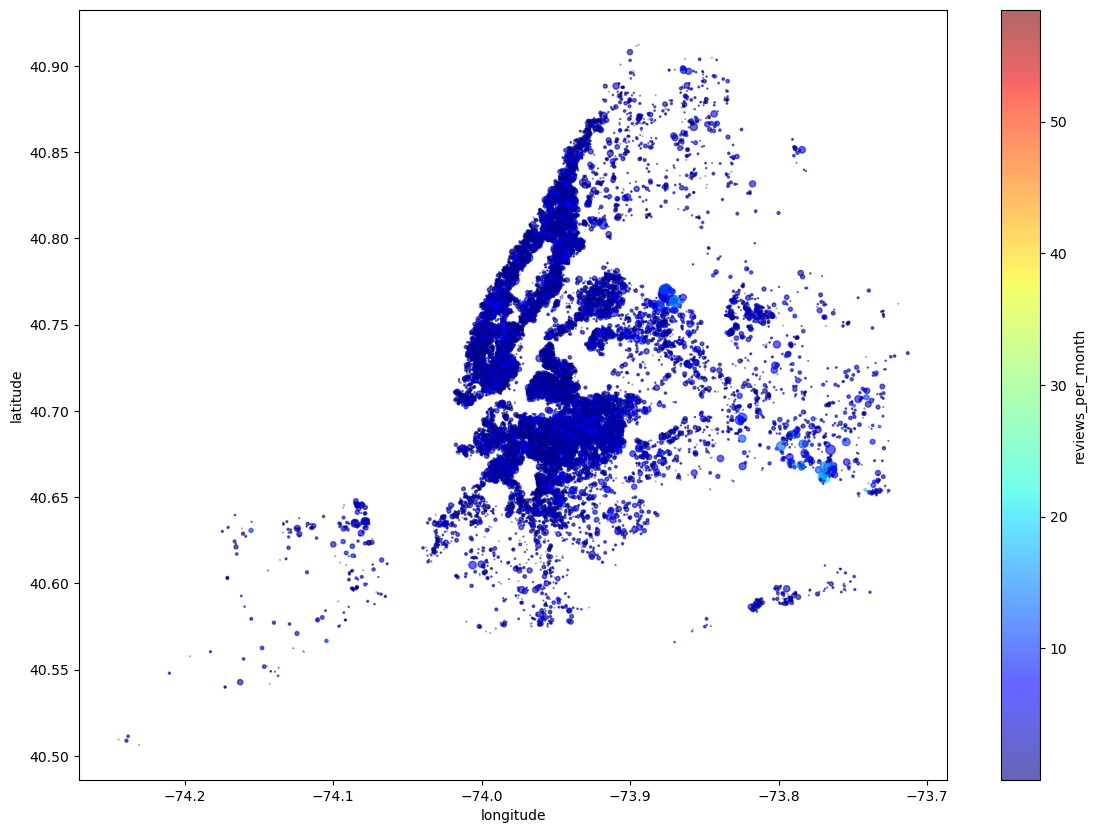

In [11]:
train_df.plot(
    kind="scatter",
    x="longitude",
    y="latitude",
    alpha=0.6,
    s=train_df["number_of_reviews"]*0.1,
    figsize=(14, 10),
    c="reviews_per_month",
    cmap=plt.get_cmap("jet"),
    colorbar=True,
    sharex=False,
)


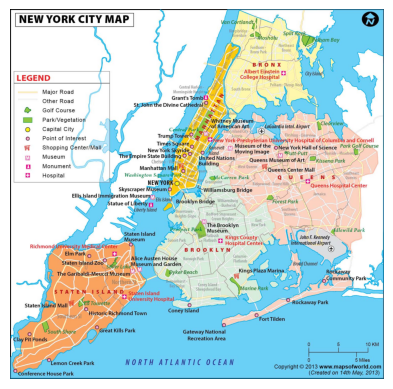

In [12]:
img = mpimg.imread("ny.jpg")
plt.imshow(img)
plt.axis("off") 
plt.show()

- After comparing this graph with a map of New York. I find it interesting that some places with more number of reviews are noticeably coming from Manhatten, Brooklyn and Queens, where you can see some yellowish and red points. On the other hand, places like the Bronx, and Staten island get much less reviews. 

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'host_id'}>,
        <Axes: title={'center': 'latitude'}>],
       [<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'minimum_nights'}>],
       [<Axes: title={'center': 'number_of_reviews'}>,
        <Axes: title={'center': 'reviews_per_month'}>,
        <Axes: title={'center': 'calculated_host_listings_count'}>],
       [<Axes: title={'center': 'availability_365'}>, <Axes: >, <Axes: >]],
      dtype=object)

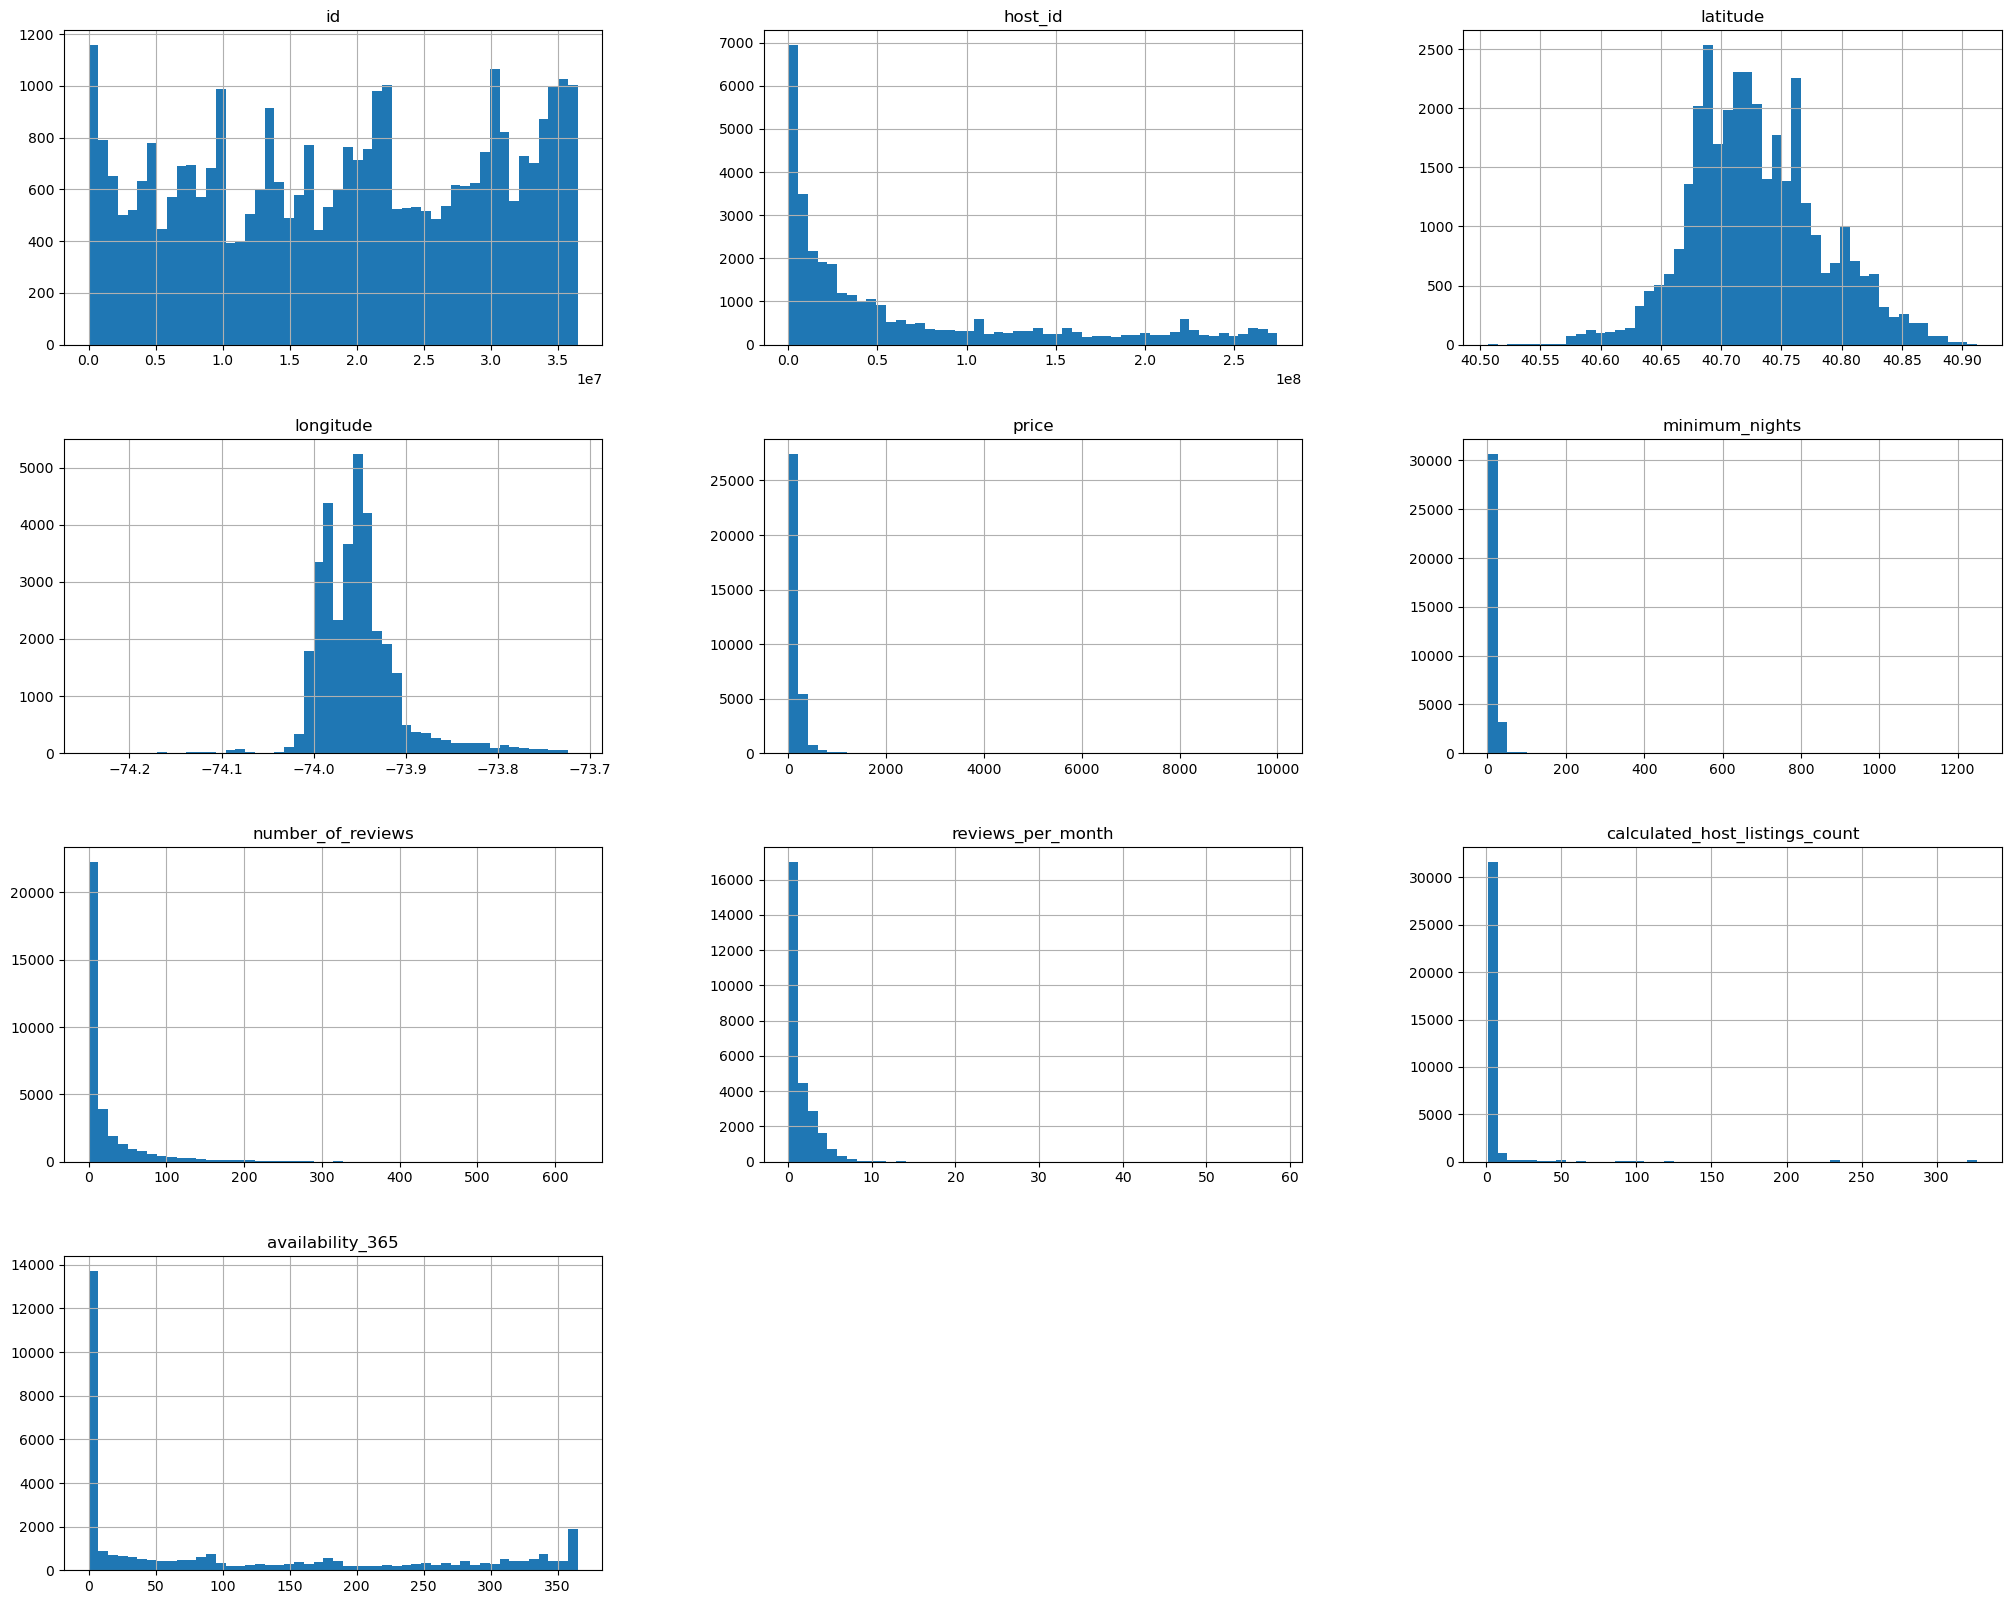

In [13]:
train_df.hist(bins=50, figsize=(25, 20))

Looking at the histogram of the numerical features,we can see that most of our features are right-skewed, and that we have a few outliers that we can see in calculated host listings count. 

### Summary

- My initial observations about the data tells me that there are a processing processes that we need to do on the data before we can train and fit it. This includes filling all of the null values with something, probably the mean. As well as dropping some columns, such as hostid and id, that may not be relevant to predicting the number of reviews. From the scatter plot, I also noticed that the latitude and longitude of these airbnbs seemed to have an effect on the number of reviews, which may also correlate to the neighbourhood group column in the dataset. 

### Metric
- Since this is a regression task, I decided that the R squared metric is a good choice for this example, since we want to see well our model fits the data


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 4. Feature engineering <a name="4"></a>
<hr>
rubric={points:1}

**Your tasks:**

1. Carry out feature engineering. In other words, extract new features relevant for the problem and work with your new feature set in the following exercises. You may have to go back and forth between feature engineering and preprocessing. 

<div class="alert alert-warning">
    
Solution_4
    
</div>

_Points:_ 1

I feel that a possible new feature could be price per night, which is easily found by price / minimum nights

In [14]:
X_train = X_train.assign(
    price_per_night = X_train["price"] / X_train["minimum_nights"]
)

X_test = X_test.assign(
    price_per_night = X_test["price"] / X_test["minimum_nights"]
)

Interesting Note
- I added this feature after performing a lot of the other steps, and I noticed an increase in test and training score after adding this feature

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 5. Preprocessing and transformations <a name="5"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Identify different feature types and the transformations you would apply on each feature type. 
2. Define a column transformer, if necessary. 

<div class="alert alert-warning">
    
Solution_5
    
</div>

_Points:_ 10

In [15]:
#these do not help determine the number of reviews, id doesn't help, host_id doesn't help, 
# and it wouldn't make sense to consider that a host's name would impact this
# upon reading piazza, last_review was recommended to not be used in predicting
drop_columns = ['id', 'host_id', 'host_name', 'last_review']

# these features are all numerical, will need simple imputer to fill NaN values
numeric_columns = ['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'availability_365', 'price_per_night']

# these features were all ones that had some sort of category, none were ordinal categories as there wasn't any meaningful ranking in any of these
categorical_columns = ['neighbourhood_group', 'neighbourhood', 'room_type']

# will need to apply count vectorizer on this feature
text_column = 'name'

In [16]:
numeric_transformer = make_pipeline(
    SimpleImputer(strategy="median"), 
    StandardScaler()
)

categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

text_transformer = CountVectorizer(max_features=100, stop_words="english")


In [17]:
ct = make_column_transformer(
    (numeric_transformer, numeric_columns),
    (categorical_transformer, categorical_columns),
    (text_transformer, text_column),
    ('drop', drop_columns)
)

In [18]:
...

Ellipsis

In [19]:
...

Ellipsis

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 6. Baseline model <a name="6"></a>
<hr>
rubric={points:2}

**Your tasks:**
1. Try `scikit-learn`'s baseline model and report results.

<div class="alert alert-warning">
    
Solution_6
    
</div>

_Points:_ 2

In [20]:
results = {}

In [21]:
baseline_model = DummyRegressor(strategy="median")

In [22]:
results["dummy"] = mean_std_cross_val_scores(baseline_model, X_train, y_train, cv=5, return_train_score=True, scoring='r2')

In [23]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.012 (+/- 0.001),0.001 (+/- 0.000),-0.197 (+/- 0.012),-0.197 (+/- 0.005)


This means that on average, the dummy regressor predicts approximately 27 reviews off from the actual amount of reviews. However, notcing that the mean absolute error is over 100% is saying that the dummy regressor's predictions are much greater than the actual number of reviews. 

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 7. Linear models <a name="7"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Try a linear model as a first real attempt. 
2. Carry out hyperparameter tuning to explore different values for the complexity hyperparameter. 
3. Report cross-validation scores along with standard deviation. 
4. Summarize your results.

<div class="alert alert-warning">
    
Solution_7
    
</div>

_Points:_ 10

_Type your answer here, replacing this text._

In [24]:
pipeline = Pipeline(steps=[
    ('preprocessor', ct),  # Preprocessing with the column transformer
    ('model', Ridge())  # Linear regression model
])
results["linear"] = mean_std_cross_val_scores(pipeline, X_train, y_train, cv=5, return_train_score=True, scoring='r2')


In [25]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.012 (+/- 0.001),0.001 (+/- 0.000),-0.197 (+/- 0.012),-0.197 (+/- 0.005)
linear,0.493 (+/- 0.076),0.084 (+/- 0.022),0.399 (+/- 0.035),0.414 (+/- 0.010)


In [26]:
from sklearn.model_selection import GridSearchCV

pipe = make_pipeline(ct, Ridge())

param_grid = {
    "columntransformer__countvectorizer__max_features": [1, 10, 100, 1000, 10000],
    "ridge__alpha": [0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
}

# Create a grid search object 
gs = GridSearchCV(pipe, 
                  param_grid = param_grid, 
                  n_jobs=-1, 
                  return_train_score=True
                 )

In [27]:
gs.fit(X_train, y_train)
best_model = gs.best_estimator_
gs.best_params_

{'columntransformer__countvectorizer__max_features': 10000, 'ridge__alpha': 10}

In [28]:
results["bestlinear"] = mean_std_cross_val_scores(best_model, X_train, y_train, cv=5, return_train_score=True, scoring='r2')


In [29]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.012 (+/- 0.001),0.001 (+/- 0.000),-0.197 (+/- 0.012),-0.197 (+/- 0.005)
linear,0.493 (+/- 0.076),0.084 (+/- 0.022),0.399 (+/- 0.035),0.414 (+/- 0.010)
bestlinear,0.359 (+/- 0.035),0.058 (+/- 0.010),0.411 (+/- 0.035),0.474 (+/- 0.011)


### Results

- It seems as if my current best linear model model can only predict a pretty poor score of 0.4096. Even so, it is performing better than the dummy regressor who's strategy is to just predict the median of the the y values. 
- I decided on using the median for both the simple inputer and dummy regressor because it helps prevent against outliers, which greatly affects mean values.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 8. Different models <a name="8"></a>
<hr>
rubric={points:12}

**Your tasks:**
1. Try at least 3 other models aside from a linear model. One of these models should be a tree-based ensemble model. 
2. Summarize your results in terms of overfitting/underfitting and fit and score times. Can you beat a linear model? 

<div class="alert alert-warning">
    
Solution_8
    
</div>

_Points:_ 12

_Type your answer here, replacing this text._

In [30]:
from lightgbm.sklearn import LGBMRegressor
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier, RandomForestRegressor


In [31]:
pipe_rf = make_pipeline(
    ct, RandomForestRegressor(max_depth=4, n_estimators=3, random_state=123)
)
pipe_xgb = make_pipeline(
    ct,
    XGBRegressor(
        random_state=123, verbosity=0
    ),
)
pipe_lgbm = make_pipeline(
    ct, LGBMRegressor(random_state=123, verbose=-1)
)

regressors = {
    "random forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
}


In [32]:
for (name, model) in regressors.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, cv=5, return_train_score=True, scoring='r2'
    )

c:\Users\kevin\miniconda3\envs\cpsc330\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\kevin\miniconda3\envs\cpsc330\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\kevin\miniconda3\envs\cpsc330\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\kevin\miniconda3\envs\cpsc330\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\kevin\miniconda3\envs\cpsc330\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with f

In [33]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.012 (+/- 0.001),0.001 (+/- 0.000),-0.197 (+/- 0.012),-0.197 (+/- 0.005)
linear,0.493 (+/- 0.076),0.084 (+/- 0.022),0.399 (+/- 0.035),0.414 (+/- 0.010)
bestlinear,0.359 (+/- 0.035),0.058 (+/- 0.010),0.411 (+/- 0.035),0.474 (+/- 0.011)
random forest,1.178 (+/- 0.074),0.107 (+/- 0.009),0.507 (+/- 0.040),0.530 (+/- 0.012)
XGBoost,1.760 (+/- 0.092),0.127 (+/- 0.006),0.608 (+/- 0.030),0.775 (+/- 0.003)
LightGBM,1.005 (+/- 0.033),0.116 (+/- 0.006),0.606 (+/- 0.038),0.694 (+/- 0.006)


### Summary
- Looking at the different models, we can see that the two better models include XGBoost with a test score of 0.608 and LightGBM with a test score of 0.606. It seems that the models slightly overfit since their training scores are higher, but not significally higher, which is a good sign. 
- Comparing to the dummy regressor, our results seem pretty good and these results are before hyperparameter optimization, which could generate even better results. 
- All of these 3 models that I tried do better than our best linear model, with the best hyperparameter, and I think that we can still do better. 

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 9. Feature selection <a name="9"></a>
<hr>
rubric={points:2}

**Your tasks:**

Make some attempts to select relevant features. You may try `RFECV` or forward selection for this. Do the results improve with feature selection? Summarize your results. If you see improvements in the results, keep feature selection in your pipeline. If not, you may abandon it in the next exercises. 

<div class="alert alert-warning">
    
Solution_9
    
</div>

_Points:_ 2

_Type your answer here, replacing this text._

In [34]:
from sklearn.feature_selection import RFECV


rfe_pipe = make_pipeline(
    ct,
    RFECV(Ridge(max_iter=1000), cv=10),
    RandomForestRegressor(n_estimators=100, random_state=42),
)

scores = cross_validate(rfe_pipe, X_train, y_train, return_train_score=True, n_jobs=-1)

In [35]:
pd.DataFrame(scores).mean()

fit_time       1005.830423
score_time        0.613894
test_score        0.597387
train_score       0.943550
dtype: float64

<!-- END QUESTION -->

<br><br>

The training score is much higher than the other models, but has a slightly worse test score than XGBoost and LightGBM. Although the training score is higher, this indicates a lot of overfitting as the model is able to do well on the training data, but performs not too well on new data. I think it may be more beneficial to remove feature selection in my pipeline due to this reason. 

<!-- BEGIN QUESTION -->

## 10. Hyperparameter optimization <a name="10"></a>
<hr>
rubric={points:10}

**Your tasks:**

Make some attempts to optimize hyperparameters for the models you've tried and summarize your results. In at least one case you should be optimizing multiple hyperparameters for a single model. You may use `sklearn`'s methods for hyperparameter optimization or fancier Bayesian optimization methods. 
  - [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)   
  - [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  - [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize) 

<div class="alert alert-warning">
    
Solution_10
    
</div>

_Points:_ 10

_Type your answer here, replacing this text._

In [36]:
pipe_rf = make_pipeline(
    ct, RandomForestRegressor(random_state=123)
)
pipe_xgb = make_pipeline(
    ct,
    XGBRegressor(
        random_state=123
    ),
)
pipe_lgbm = make_pipeline(
    ct, LGBMRegressor(random_state=123)
)

In [37]:
forest_param_grid = {
    "randomforestregressor__n_estimators": [1, 5, 10, 100, 200],
}

fgs = GridSearchCV(pipe_rf,
                   param_grid = forest_param_grid,
                   n_jobs=-1,
                   return_train_score=True)

fgs.fit(X_train, y_train)
bestforest = fgs.best_estimator_
print(fgs.best_params_)

{'randomforestregressor__n_estimators': 200}


In [38]:
xgb_param_grid = {
    "xgbregressor__alpha": [0, 10, 100, 1000, 10000]
}

xgbgs = GridSearchCV(pipe_xgb,
                   param_grid = xgb_param_grid,
                   n_jobs=-1,
                   return_train_score=True)

xgbgs.fit(X_train, y_train)
bestxgb = xgbgs.best_estimator_
print(xgbgs.best_params_)

{'xgbregressor__alpha': 10}


In [39]:
lgbm_param_grid = {
    "lgbmregressor__n_estimators": [1, 5, 10, 100, 200],
}

lgbmgs = GridSearchCV(pipe_lgbm,
                   param_grid = lgbm_param_grid,
                   n_jobs=-1,
                   return_train_score=True)

lgbmgs.fit(X_train, y_train)
bestlgbmgs = lgbmgs.best_estimator_
print(lgbmgs.best_params_)

{'lgbmregressor__n_estimators': 200}


In [40]:
results["bestforest"] = mean_std_cross_val_scores(bestforest, X_train, y_train, cv=5, return_train_score=True, scoring='r2')
results["bestxgb"] = mean_std_cross_val_scores(bestxgb, X_train, y_train, cv=5, return_train_score=True, scoring='r2')
results["bestlgbm"] = mean_std_cross_val_scores(bestlgbmgs, X_train, y_train, cv=5, return_train_score=True, scoring='r2')

c:\Users\kevin\miniconda3\envs\cpsc330\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\kevin\miniconda3\envs\cpsc330\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\kevin\miniconda3\envs\cpsc330\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\kevin\miniconda3\envs\cpsc330\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\kevin\miniconda3\envs\cpsc330\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with f

In [41]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.012 (+/- 0.001),0.001 (+/- 0.000),-0.197 (+/- 0.012),-0.197 (+/- 0.005)
linear,0.493 (+/- 0.076),0.084 (+/- 0.022),0.399 (+/- 0.035),0.414 (+/- 0.010)
bestlinear,0.359 (+/- 0.035),0.058 (+/- 0.010),0.411 (+/- 0.035),0.474 (+/- 0.011)
random forest,1.178 (+/- 0.074),0.107 (+/- 0.009),0.507 (+/- 0.040),0.530 (+/- 0.012)
XGBoost,1.760 (+/- 0.092),0.127 (+/- 0.006),0.608 (+/- 0.030),0.775 (+/- 0.003)
LightGBM,1.005 (+/- 0.033),0.116 (+/- 0.006),0.606 (+/- 0.038),0.694 (+/- 0.006)
bestforest,104.720 (+/- 4.109),0.522 (+/- 0.041),0.605 (+/- 0.028),0.945 (+/- 0.001)
bestxgb,0.781 (+/- 0.019),0.095 (+/- 0.010),0.615 (+/- 0.027),0.769 (+/- 0.003)
bestlgbm,0.557 (+/- 0.071),0.092 (+/- 0.010),0.611 (+/- 0.037),0.737 (+/- 0.005)


In [42]:
print("Random Forest params: ", fgs.best_params_)
print("XGBoost params: ", xgbgs.best_params_)
print("LGBM params: ", lgbmgs.best_params_)

Random Forest params:  {'randomforestregressor__n_estimators': 200}
XGBoost params:  {'xgbregressor__alpha': 10}
LGBM params:  {'lgbmregressor__n_estimators': 200}


After attempting hyperparameter optimization on some models, such as random forest, xgboost, and lgmbregressor, I found that the best test_score still belongs to XGBRegressor, except now with an alpha value of 10. Although LGBMRegressor also saw a increase with hyperparameter optimization, it's still slightly worse than XGBRegressor. On the other hand, our best random forest took a very long to fit due to the amount of estimators, which did provide a very high training score, but still an average test score which indicates overfitting. 

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 11. Interpretation and feature importances <a name="1"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Use the methods we saw in class (e.g., `shap`) (or any other methods of your choice) to examine the most important features of one of the non-linear models. 
2. Summarize your observations. 

<div class="alert alert-warning">
    
Solution_11
    
</div>

_Points:_ 10

I will use SHAP to examine our best XGBRegressor model. 

In [43]:
ct.fit(X_train)

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['latitude', 'longitude', 'price',
                                  'minimum_nights', 'number_of_reviews',
                                  'calculated_host_listings_count',
                                  'availability_365', 'price_per_night']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['neighbourhood_group', 'neighbourhood',
                                  'room_type']),
                                ('countvectorizer',
                                 CountVectorizer(max_features=100,
                                                 stop_words='english'),
                                 'name'),
                                ('drop', 'drop',
                                 ['id', 'host_id', 'host_name',
                                  'last_review'])])

In [44]:
X_train_enc = pd.DataFrame(
    data=ct.transform(X_train),
    columns=ct.get_feature_names_out(),
    index=X_train.index,
)

In [45]:
model = XGBRegressor(alpha=10)
model.fit(X_train_enc, y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, ...)

In [46]:
import shap
explainer = shap.Explainer(model)

In [47]:
shap_values = explainer(X_train_enc)

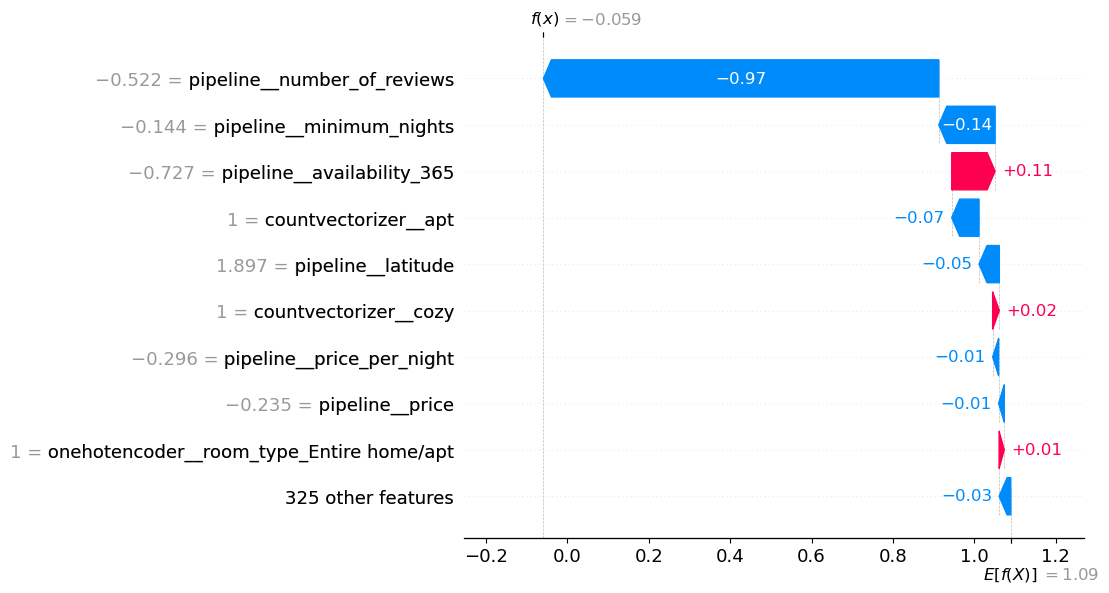

In [48]:
shap.plots.waterfall(shap_values[0])

Looking at our SHAP graph, we see that the biggest feature contributor to our predictions is the number of reviews, which correlates to what we are predicting, the number of reviews per month. However, I found it interesting that the number of reviews has a negative SHAP value, which decreases the number of reviews per month that we are predicting. Although I understand that the weight values do not reflect reality exactly, just as speculation, it could be that in the real-world, airbnb's with more review are older listenings and may not be getting as many reviews per month currently. Moreover, some positive features include 365 availability, the word 'cozy' in the title and the room type being Entire home/apt, which in the real world are likely to positivly impact the number of reviews. 

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 12. Results on the test set <a name="12"></a>
<hr>

rubric={points:10}

**Your tasks:**

1. Try your best performing model on the test data and report test scores. 
2. Do the test scores agree with the validation scores from before? To what extent do you trust your results? Do you think you've had issues with optimization bias? 
3. Take one or two test predictions and explain these individual predictions (e.g., with SHAP force plots).  

<div class="alert alert-warning">
    
Solution_12
    
</div>

_Points:_ 10

_Type your answer here, replacing this text._

In [49]:
model = XGBRegressor(alpha=10)
best_model = make_pipeline(ct, model)
best_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['latitude', 'longitude',
                                                   'price', 'minimum_nights',
                                                   'number_of_reviews',
                                                   'calculated_host_listings_count',
                                                   'availability_365',
                                                   'price_per_night']),
                                                 ('onehotencoder',
                                                  OneHot...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [50]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.012 (+/- 0.001),0.001 (+/- 0.000),-0.197 (+/- 0.012),-0.197 (+/- 0.005)
linear,0.493 (+/- 0.076),0.084 (+/- 0.022),0.399 (+/- 0.035),0.414 (+/- 0.010)
bestlinear,0.359 (+/- 0.035),0.058 (+/- 0.010),0.411 (+/- 0.035),0.474 (+/- 0.011)
random forest,1.178 (+/- 0.074),0.107 (+/- 0.009),0.507 (+/- 0.040),0.530 (+/- 0.012)
XGBoost,1.760 (+/- 0.092),0.127 (+/- 0.006),0.608 (+/- 0.030),0.775 (+/- 0.003)
LightGBM,1.005 (+/- 0.033),0.116 (+/- 0.006),0.606 (+/- 0.038),0.694 (+/- 0.006)
bestforest,104.720 (+/- 4.109),0.522 (+/- 0.041),0.605 (+/- 0.028),0.945 (+/- 0.001)
bestxgb,0.781 (+/- 0.019),0.095 (+/- 0.010),0.615 (+/- 0.027),0.769 (+/- 0.003)
bestlgbm,0.557 (+/- 0.071),0.092 (+/- 0.010),0.611 (+/- 0.037),0.737 (+/- 0.005)


In [51]:
print( "Training score: ", best_model.score(X_train, y_train))
print("Test score: ", best_model.score(X_test, y_test))

Training score:  0.7563570226709284
Test score:  0.6042935737415125


Looking at the test score of 0.604, compared to the other models' test scores, I would say that it is predicting around as expected, and does ever so slightly worse on the test data. I generally trust my scores and I think that there may be a bit of optimization bias where our training score is around 15% higher than our test score, which indicates overfitting. 

In [52]:
ct.fit(X_test)

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['latitude', 'longitude', 'price',
                                  'minimum_nights', 'number_of_reviews',
                                  'calculated_host_listings_count',
                                  'availability_365', 'price_per_night']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['neighbourhood_group', 'neighbourhood',
                                  'room_type']),
                                ('countvectorizer',
                                 CountVectorizer(max_features=100,
                                                 stop_words='english'),
                                 'name'),
                                ('drop', 'drop',
                                 ['id', 'host_id', 'host_name',
                                  'last_review'])])

In [53]:
X_train_enc = pd.DataFrame(
    data=ct.transform(X_train),
    columns=ct.get_feature_names_out(),
    index=X_train.index,
)

X_test_enc = pd.DataFrame(
    data=ct.transform(X_test),
    columns=ct.get_feature_names_out(),
    index=X_test.index,
)

In [54]:
model = best_model.named_steps["xgbregressor"].fit(X_train_enc, y_train)

In [55]:
explainer = shap.Explainer(model)
train_shap_values = explainer(X_train_enc) # train shap values
test_shap_values = explainer(X_test_enc) # test shap values 

In [56]:
ex1_idx = 10

In [57]:
shap.initjs()

In [58]:
shap.force_plot(explainer.expected_value, test_shap_values.values[ex1_idx, :], X_test_enc.iloc[ex1_idx, :])

In this SHAP force plot, we can takeaway that the average prediction across all data points is 1.09 and our final prediction for this particular point is 0.40. It seems that the number of reviews is still a big decreaser in the the predictions whilst the airbnb being located in the manhattan was a positive influence in the prediction. On ther other hand, the negative price value pushed the predictions higher whilst the category of entire home/apt being 0 negativly impacted the prediction. Although some of these weights may represent real-life correleations, some of these features are also simply what the machine learned. 

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 13. Summary of results <a name="13"></a>
<hr>
rubric={points:12}

Imagine that you want to present the summary of these results to your boss and co-workers. 

**Your tasks:**

1. Create a table summarizing important results. 
2. Write concluding remarks.
3. Discuss other ideas that you did not try but could potentially improve the performance/interpretability . 
3. Report your final test score along with the metric you used at the top of this notebook in the [Submission instructions section](#si).

<div class="alert alert-warning">
    
Solution_13
    
</div>

_Points:_ 12

_Type your answer here, replacing this text._

In [59]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.012 (+/- 0.001),0.001 (+/- 0.000),-0.197 (+/- 0.012),-0.197 (+/- 0.005)
linear,0.493 (+/- 0.076),0.084 (+/- 0.022),0.399 (+/- 0.035),0.414 (+/- 0.010)
bestlinear,0.359 (+/- 0.035),0.058 (+/- 0.010),0.411 (+/- 0.035),0.474 (+/- 0.011)
random forest,1.178 (+/- 0.074),0.107 (+/- 0.009),0.507 (+/- 0.040),0.530 (+/- 0.012)
XGBoost,1.760 (+/- 0.092),0.127 (+/- 0.006),0.608 (+/- 0.030),0.775 (+/- 0.003)
LightGBM,1.005 (+/- 0.033),0.116 (+/- 0.006),0.606 (+/- 0.038),0.694 (+/- 0.006)
bestforest,104.720 (+/- 4.109),0.522 (+/- 0.041),0.605 (+/- 0.028),0.945 (+/- 0.001)
bestxgb,0.781 (+/- 0.019),0.095 (+/- 0.010),0.615 (+/- 0.027),0.769 (+/- 0.003)
bestlgbm,0.557 (+/- 0.071),0.092 (+/- 0.010),0.611 (+/- 0.037),0.737 (+/- 0.005)


I feel that this results table was a great summary of this entire project. I began with a baseline, which was a dummy regressor that simply predicted the average, and as we can see, it performed terribly as expected. However, as I tried a linear model and optimzed its parameters, its scores slowly started to perform a bit better. As I tested 3 non-linear models, random-forest, XGBRegressor, and LightGBM, the results were around 20% better than the linear model which was a big improvement, probably because as we learned in class, these ensemble methods perform much better than singular models. I then attempted hyper-parameter optimization, which for random-forest, took a long time, and produced great training scores but much worse test scores due to overfitting. On the other hand, I found that our best XGBRegressor model with alpha=10 was our best model overall and used it for the test data. In the end, I was only able to get a 60.4% accuracy on the test data. I also attempted to do some feature engineering, by creating a new feature called price_per_night and as a result, I noticed that adding it gave a very slight boost in performance.

I think some other ideas for that I did not try was to possibly engineer some more features, which could possibly and also possibly not benefit the predictions. On the other hand, I could have tried to use more hyperparameters during hyperparameter optimzation, but I found that the process of doing grid search on more than one hyperparameter took a really long time. However, I am almost certain that if I used more hyperparameters, it would have made some of the models perform much better. Similarily, doing feature selection RFECV took an extremely long time, and I also didn't see great results, so in the end, it was something that I decided wouldn't be beneficial to this project. 

<br><br>

<!-- BEGIN QUESTION -->

## 14. Your takeaway <a name="15"></a>
<hr>
rubric={points:2}

**Your tasks:**

What is your biggest takeaway from the supervised machine learning material we have learned so far? Please write thoughtful answers.  

<div class="alert alert-warning">
    
Solution_14
    
</div>

_Points:_ 2

Overall, I am very satisted with this project and I learned a lot more and got some more hands on work with applied machine learning. I think my biggest takeaway from the supervised machine learning material we have learned so far is that understanding the dataset and being able to effectivly preprocess the data is the most important part in the training of a model. I now understand the saying "garbage in, garbage out" well, and how if we are taking terrible data in, we will only get terrible results. 

<!-- END QUESTION -->

<br><br>

**PLEASE READ BEFORE YOU SUBMIT:** 

When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from "1" will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
4. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 
5. Make sure that the plots and output are rendered properly in your submitted file. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb so that the TAs can view your submission on Gradescope. 

This was a tricky one but you did it! 

![](img/eva-well-done.png)